# Table of Contents
* [1. load](#1.-load)
* [2. simple words](#2.-simple-words)
* [3. filtering sample](#3.-filtering-sample)
* [4. tag sentences](#4.-tag-sentences)
* [5. parse npc extraction](#5.-parse-npc-extraction)
* [6. clean and spellcheck](#6.-clean-and-spellcheck)
* [7. MS coco captions](#7.-MS-coco-captions)
	* [7.1 phrases from captions](#7.1-phrases-from-captions)
	* [7.2 parse exp](#7.2-parse-exp)
* [8. german experiments](#8.-german-experiments)
* [9. wordnet](#9.-wordnet)


In [307]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import pickle
import os
import json
from tqdm import tqdm
from tqdm import tqdm_notebook

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [308]:
from eda import *

# 1. load

In [7]:
icon_list = os.listdir('/Users/schwenk/wrk/pictionary/vision-pictionary/iconary_webgame/public/images/')
icon_list = [i[:-4] for i in icon_list]

In [8]:
out_data_dir = '/Users/schwenk/wrk/pictionary/phrase_gen/sandbox-anikem/out/'

In [9]:
verb_df = pd.read_csv(out_data_dir + 'verbs.txt', header=None, names=['verb'])
situations_df = pd.read_csv(out_data_dir + 'full_situations.txt', header=None, names=['situation'])

situations_df['len'] = situations_df['situation'].apply(lambda x: len(x.split()))
verb_df['len'] = verb_df['verb'].apply(lambda x: len(x))

In [10]:
situations_df.head(1)

,situation,len
0,the person loads a cartridge holder,6


In [12]:
common_verbs = verb_df[verb_df['verb'].apply(lambda x: least_common_word(x))]

In [309]:
common_verbs.head(1)

,verb,len
5,applying,8


In [88]:
# _ = situations_df['len'].hist(bins=12)
# verb_df.sort_values('len')
# ing_verbs = verb_df[verb_df['verb'].str.contains('ing')]

not abstract, easy

# 2. simple words

In [15]:
word_data_dir = '/Users/schwenk/wrk/pictionary/BasicEnglishTranslator/data/'

In [16]:
with open('./data/basic_words.csv') as f:
    read_article = f.read()

with open(word_data_dir + 'basic_english.pickle', 'rb') as f:
    all_words = pickle.load(f) 

In [310]:
simple_words = pd.read_csv(word_data_dir + 'basic_english_words.csv')
simple_words.head(1)

,WORD
0,a


# 3. filtering sample

In [174]:
description_corpus = ' '.join(situations_df['situation'])

tokenized_corpus = word_tokenize(description_corpus)

normalized_tokens = []
for toke in tokenized_corpus:
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

In [23]:
word_counts = Counter(normalized_tokens)
most_common = word_counts.most_common(200)

In [24]:
filtered_words = [w for w, count in word_counts.items() if count == 1]

In [95]:
sentences = list(set(situations_df['situation'].tolist()))

In [33]:
# sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(sentences))

In [165]:
len(passed_sents) / len(sentences)

0.9645086556406461

In [164]:
len(passed_sents)

59950

# 4. tag sentences

In [52]:
with open('./data/unique_parsed_sents.pkl', 'rb') as f:
    unique_parsed_sents = pickle.load(f)

In [216]:
simple_sentences = [sent for sent in unique_parsed_sents if least_common_word(sent, 3.7)]

In [417]:
word_blacklist = set(['uses', 'using', 'people', 'helped', 'measures', 'records', 'data', 'works', 'teach', 'body', 'with', 'training', 'waste', 'plastic', 'gravity', 'commission', 'space'] + colors)

In [424]:
blacklist_removed = [s for s in simple_sentences if not set([w.lower() for w in s.split()]).intersection(word_blacklist)]

In [223]:
len(blacklist_removed)

14487

In [183]:
freq_filt_words = [t for t in normalized_tokens if filter_on_freq(t, 4.7, 3)]

In [428]:
chosen_sample = blacklist_removed
tagged_sentences = [get_pos_tags(s) for s in chosen_sample]

In [430]:
vocab_complete = list(set(normalized_tokens))
vocab = list(set([w[0].lower() for s in tagged_sentences for w in s if w[1] in ['NN', 'NNS', 'NNP', 'NNPS']]))

In [431]:
voc_ser = pd.Series(vocab)
voc_ser.to_csv('cleaned_sentences_nouns_harder.txt', index=False, header=None)

# 5. parse npc extraction

In [24]:
s1 = constituent_parse[1]
TreeView(s1)._cframe.print_to_file('s2.ps')

In [2231]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
  {<NNP>+}                # chunk sequences of proper nouns
  {<NN>+}                 # chunk consecutive nouns
  """




cp = nltk.RegexpParser(grammar)
parsed_sent = cp.parse(sent_parses[0])
for npstr in extract_np(parsed_sent):
    print (npstr)

The red-haired businessman
accountant
the phone
his office


In [100]:
def extract_np(psent):
    for subtree in psent.subtrees():
        if subtree.label() == 'NP':
            subprod = subtree.productions()[0].unicode_repr()
            if 'NN' in subprod or 'NNP' in subprod:
                yield ' '.join(word for word in subtree.leaves())


def compute_token_spans(const_parse_sent, txt):
    tokens = const_parse_sent.leaves()
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        yield token, offset, offset+len(token)
        offset += len(token)

        
def assign_word_spans(noun_phrases_w_spans, doc, token_spans):
    chunk_spans = []
    for np in noun_phrases_w_spans:
        char_span = [(m.start(), m.end()) for m in re.finditer(np, doc)][0]
        start, end = char_span
        start_w, end_w = None, None
        for w_idx, token_span in enumerate(token_spans):
            token, ts, te = token_span
            if ts == start:
                start_w = w_idx
            if te == end:
                end_w = w_idx + 1
        if type(start_w) == int and type(end_w) == int:
            chunk_spans.append([start_w, end_w])
        else:
            print('failed')
    return chunk_spans


def np_chunker(doc, parsed_sents):
    noun_phrases = [list(extract_np(sent)) for sent in parsed_sents]
#     noun_phrase_spans = [list(extract_np_spans(doc, sent)) for sent in noun_phrases]
    token_spans = [list(compute_token_spans(sent, doc)) for sent in parsed_sents]
    noun_phrase_spans = [assign_word_spans(noun_phrases[n], doc, token_spans[n]) for n in range(len(parsed_sents))]
    return {'chunks': noun_phrase_spans, 'named_chunks': noun_phrases}

# 6. clean and spellcheck

# 7. MS coco captions

## 7.1 phrases from captions

In [20]:
with open('/Users/schwenk/wrk/pictionary/coco/annotations/captions_train2014.json') as f:
    coco_captions = json.load(f)

In [21]:
caption_sentences = [c['caption'] for c in coco_captions['annotations']]

In [22]:
len(caption_sentences)

414113

In [23]:
caption_corpus = [w for s in tqdm(caption_sentences) for w in word_tokenize(s)]
# tokenized_corpus = word_tokenize(caption_corpus)

In [312]:
caption_token_set = list(set(caption_corpus))

normalized_tokens = []
for toke in tqdm(caption_corpus):
    clean_toke = toke.strip().lower()
    if clean_toke not in cached_sw and clean_toke:
        normalized_tokens.append(clean_toke)

token_counts = Counter(normalized_tokens)

token_counts.most_common(10)

[('man', 51530),
 ('sitting', 36823),
 ('two', 34093),
 ('standing', 30060),
 ('people', 29662),
 ('next', 25916),
 ('white', 25383),
 ('woman', 24220),
 ('table', 21318),
 ('street', 21190)]

In [28]:
len(normalized_tokens)

2397308

In [302]:
random.choice(caption_sentences)

'Three unopened wine bottles are next to wine glasses.'

In [30]:
cap_df = pd.DataFrame(caption_sentences)
cap_df.columns = ['cap']

In [31]:
cap_df['len'] = cap_df['cap'].str.len()

In [32]:
# _ = cap_df['len'].hist(bins=30)

In [33]:
cap_len_thresh = 30
short_caps = cap_df[cap_df['len'] < 35]

In [34]:
short_cap_l = short_caps['cap'].tolist()

In [35]:
len(short_cap_l)

6051

In [55]:
common_short = [c for c in tqdm(short_cap_l) if least_common_word(c, 3.5)]

In [58]:
blacklist_removed = [s for s in common_short if not set([w.lower() for w in s.split()]).intersection(color_set)]

In [59]:
len(blacklist_removed)

4266

In [60]:
# voc_ser = pd.Series(blacklist_removed)
# voc_ser.to_csv('simple_coco_captions.txt', index=False, header=None)

In [66]:
sent_gram_errors, passed_sents = grammar_check_phrases(tqdm(blacklist_removed))
passed_sents = [ps for ps in passed_sents if not spellcheck_phrase(ps)]

In [67]:
normed_sents = list(set([normalize_sent(s) for s in passed_sents if 'image' not in s]))

In [68]:
tagged_sentences = [get_pos_tags(s) for s in tqdm(normed_sents)]

In [316]:
sents_w_verbs = [ts[:-1] for ts in tagged_sentences if set([t[1] for t in ts]).intersection(verb_tags)]

In [318]:
output_sentences(sents_w_verbs)

In [74]:
verbs = []
for s in sents_w_verbs:
    for w, tag in s:
        if tag in verb_tags:
            verbs.append(w)
verb_ser = pd.Series(verbs)

In [75]:
Counter(verbs).most_common(10)

[('is', 844),
 ('sitting', 171),
 ('laying', 145),
 ('has', 144),
 ('sits', 104),
 ('flying', 102),
 ('are', 100),
 ('holding', 54),
 ('eating', 50),
 ('parked', 42)]

In [77]:
normalized_tokens = []
for s in tqdm(sents_w_verbs):
    for w in s:
        normalized_tokens.append(w[0])

In [78]:
wcounts = Counter(normalized_tokens)

In [79]:
common = wcounts.most_common(40)

In [104]:
free_words_less = ['a',
 'is',
 'of',
 'the',
 'and',
 'it',
 'are',
#  'that',
 'an']

free_words = ['a',
 'on',
 'is',
 'in',
 'of',
 'the',
 'to',
 'has',
 'at',
 'that',
 'and',
 'it',
 'are',
 'up',
 'with',
 'next',
 'an',]

## 7.2 parse exp

In [305]:
reformed_sents = [' '.join(w[0] for w in sent) for sent in sents_w_verbs]

a boat is in the middle of a lake


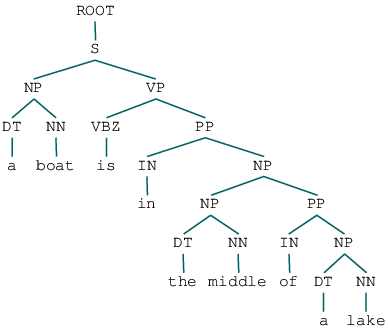

In [319]:
sent = random.choice(reformed_sents)
# sent = ''
print(sent)
constituent_parse  = [list(i)[0] for i in core_parser.raw_parse_sents([sent])][0]

constituent_parse

_interesting examples_:

a man is in a tie and suit

a cat lying on top of a keyboard

a truck is parked in a lot

the door to a toilet room is open

roses laid on the sheets of a bed

a group of men hang out together

a man flies his kite at a park

a man sits on a bench by himself

a sheep eyes a dog through a fence

a man playing tennis on a hot day

the man is at the table drinking

some items sit next to the door



In [283]:
[s for s in reformed_sents if 'sky' in s and 'plane' in s]

['an airplane is flying in the sky',
 'a plane is flying in the sky',
 'a plane flying high on a clear sky',
 'a plane flying in the sky',
 'a plane is flying up in the sky',
 'the plane is flying up in the sky',
 'a small plane is flying in the sky',
 'a large plane is flying in the sky',
 'a plane is smoking in the sky',
 'a plane flying high up in the sky',
 'a plane flying by on a cloudy sky',
 'a plane is upside down in the sky']

# 8. german experiments

In [468]:
german_words = pd.read_csv('./german_10k.txt', sep=' ', header=None).T
german_words.columns = ['raw_word']

german_words = german_words[german_words['raw_word'].str.isalpha().fillna(False)]

In [472]:
german_words['len'] = german_words.raw_word.str.len()

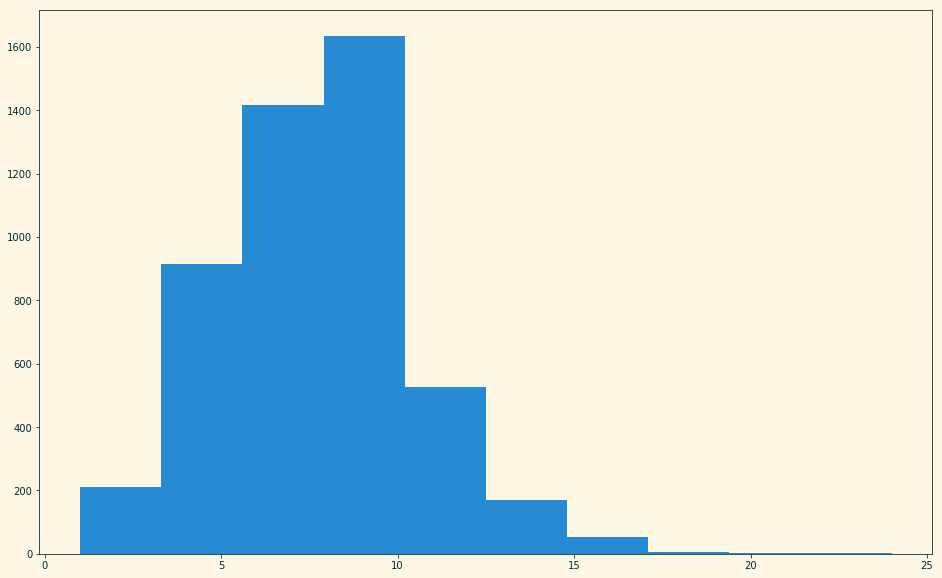

In [475]:
german_words.len.hist()

In [478]:
long_words = german_words[german_words['len'] > 15]

In [485]:
from googletrans import Translator
translator = Translator(service_urls=[
      'translate.google.com',
    ])

In [489]:
to_trans = long_words['raw_word'].tolist()

In [492]:
translations = translator.translate(to_trans, dest='en')

In [498]:
translator.translate('forest fire', dest='de').text

'Waldbrand'

In [506]:
from wiktionaryparser import WiktionaryParser

In [510]:
parser = WiktionaryParser()
word = parser.fetch('test')
another_word = parser.fetch('Aasfresser', 'german')
parser.set_default_language('french')

In [511]:
another_word

[{'definitions': [{'examples': [],
    'partOfSpeech': 'noun',
    'relatedWords': [{'relationshipType': 'synonyms',
      'words': ['Nekrophage']}],
    'text': 'Aasfresser\xa0m (genitive Aasfressers, plural Aasfresser)\nscavenger (an animal that feeds on carrion)\n'}],
  'etymology': 'Aas +\u200e Fresser (from fressen + -er "-er")',
  'pronunciations': {'audio': ['//upload.wikimedia.org/wikipedia/commons/5/52/De-Aasfresser.ogg'],
   'text': ['IPA: /ˈaːsˌfʀɛsɐ/']}}]

# 9. wordnet

In [320]:
test_word = 'toast'
sis_words, ssyns = get_word_sisters(test_word)

Synset('toast.n.01')


In [321]:
sis_words

['anadama_bread',
 'bap',
 'barmbrack',
 'breadstick',
 'bread-stick',
 'brown_bread',
 'Boston_brown_bread',
 'bun',
 'roll',
 'caraway_seed_bread',
 'challah',
 'hallah',
 'cinnamon_bread',
 'cracked-wheat_bread',
 'cracker',
 'crouton',
 'dark_bread',
 'whole_wheat_bread',
 'whole_meal_bread',
 'brown_bread',
 'English_muffin',
 'flatbread',
 'garlic_bread',
 'gluten_bread',
 'Host',
 'loaf_of_bread',
 'loaf',
 'matzo',
 'matzoh',
 'matzah',
 'unleavened_bread',
 'nan',
 'naan',
 'onion_bread',
 'quick_bread',
 'raisin_bread',
 'rye_bread',
 'salt-rising_bread',
 'simnel',
 'sour_bread',
 'sourdough_bread',
 'toast',
 'wafer',
 'white_bread',
 'light_bread']

In [565]:
tsns = ssyns[0]

In [640]:
# for syn in wordnet.synsets(test_word):
#     print(syn.definition())